In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.16.5
pandas 0.25.2
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
# print(fashion_mnist)
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]
# 打印格式
print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# 数据归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train:[None,28,28] -> [None,784]
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [4]:
# tf.keras.models.Sequential()
# 构建模型

# 深度神经网络
model = keras.models.Sequential()
# 输入数据展平
model.add(keras.layers.Flatten(input_shape=[28,28]))
# 隐藏层 20层
for _ in range(20):
    model.add(keras.layers.Dense(100,activation="selu")) # 激活函数自带归一化

model.add(keras.layers.AlphaDropout(rate=0.5))
# AlphaDropout:1. 均值和方差不变 2. 归一化性质也不变
# model.add(keras.layers.Dropout(rate=0.5))


# 输出层
model.add(keras.layers.Dense(10,activation="softmax"))



# 
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [9]:
# 回调函数 Tensorboard(文件夹）\earylystopping\ModelCheckpoint（文件名）
logdir = os.path.join("dnn-selu-dropout-callbacks")
print(logdir)
if not os.path.exists(logdir):
    os.mkdir(logdir)
# 文件名
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]
# 开始训练
history = model.fit(x_train_scaled,y_train,epochs=10,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)

dnn-selu-dropout-callbacks
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 12s 210us/sample - loss: 0.2772 - accuracy: 0.8987 - val_loss: 0.4804 - val_accuracy: 0.8890
Epoch 2/10
55000/55000 [==============================] - 11s 201us/sample - loss: 0.2682 - accuracy: 0.9038 - val_loss: 0.5641 - val_accuracy: 0.8796
Epoch 3/10
55000/55000 [==============================] - 11s 199us/sample - loss: 0.2604 - accuracy: 0.9048 - val_loss: 0.5109 - val_accuracy: 0.8826
Epoch 4/10
55000/55000 [==============================] - 11s 199us/sample - loss: 0.2540 - accuracy: 0.9089 - val_loss: 0.5380 - val_accuracy: 0.8870
Epoch 5/10
55000/55000 [==============================] - 11s 197us/sample - loss: 0.2452 - accuracy: 0.9100 - val_loss: 0.5289 - val_accuracy: 0.8852
Epoch 6/10
55000/55000 [==============================] - 11s 197us/sample - loss: 0.2408 - accuracy: 0.9125 - val_loss: 0.5726 - val_accuracy: 0.8876


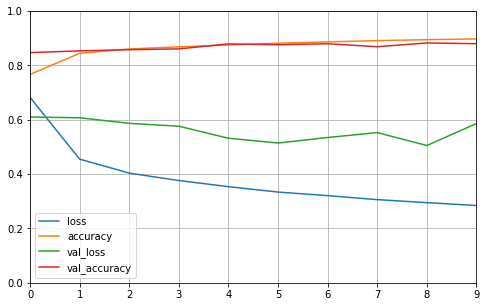

In [7]:
# 画图
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

# 损失函数，刚开始下降慢的原因
# 1. 参数众多，训练不充分
# 2. 梯度消失 -》 链式法则中
# 解决： selu缓解梯度消失

In [8]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6262179209128023, 0.8744]